# ECFP Transformation Analysis
## Bridging the Gap Between ECFPs and GNN Embeddings

**Objective**: Investigate how different transformations affect ECFP representations to make them more GNN-like while preserving molecular similarity structure.

**Key Questions**:
1. How do transformations affect downstream task performance?
2. How well do transformations preserve pairwise distance structure?
3. How do transformations change sparsity/density characteristics?

---

## 1. Setup and Imports

In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown
import pandas as pd

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Import dataset and downstream task utilities
from dataset_utils import ECFPDataset
from downstream import run_downstream_task

# Import all transformations
from transforms import (
    # Affine transformations
    Rotation, Permutation, Scaling, Translation, Shear, Reflection,
    # Continuity transformations
    GaussianNoise,
    # Normalization transformations
    L2Normalization, Standardization,
    # Nonlinear transformations
    NonlinearActivation,
    # Density transformations
    SparseToDense, AdaptiveScaling,
    # GNN-inspired transformations
    BlockRadiusLinearMixing,
    # Composition
    Compose
)

# Import analysis utilities
from pairwise_distances import (
    analyze_distance_preservation,
    compare_sparsity,
    compute_sparsity_metrics
)

from plots import plot_value_distributions

# Configure matplotlib
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✓ All imports successful!")

✓ All imports successful!


## 2. Baseline: Original ECFPs

First, we establish baseline performance using **binary** and **count** ECFP representations on the ESOL dataset (solubility prediction, regression task).

In [13]:
# Load ESOL dataset with binary ECFPs
print("Loading ESOL dataset with BINARY ECFPs...")
binary_dataset = ECFPDataset(
    name="esol",
    split_type="random",
    target_index=0,
    n_bits=2048,
    radius=2,
    use_count=False  # Binary fingerprints
)

print(f"  Dataset size: {len(binary_dataset.features)} molecules")
print(f"  Feature dimension: {binary_dataset.features.shape[1]}")
print(f"  Train/Val/Test split: {len(binary_dataset.split.train)}/{len(binary_dataset.split.valid)}/{len(binary_dataset.split.test)}")

# Compute sparsity metrics
binary_sparsity_esol = compute_sparsity_metrics(binary_dataset.features)
print(f"\n  Sparsity: {binary_sparsity_esol['zero_fraction']*100:.1f}% zeros")
print(f"  Avg non-zero features per molecule: {binary_sparsity_esol['nonzero_per_sample']:.1f}")

# Train MLP on binary ECFPs
print("Training MLP on BINARY ECFPs...\n")
binary_result = run_downstream_task(
    binary_dataset,
    task_type="regression",
    hidden_dim=128,
    epochs=100,
    lr=1e-3,
    device="cpu"
)

print("\n" + "="*60)
print("BASELINE PERFORMANCE (Binary ECFPs)")
print("="*60)
print(f"Validation RMSE: {binary_result['val']:.4f}")
print(f"Test RMSE:       {binary_result['test']:.4f}")
print("="*60)

Loading ESOL dataset with BINARY ECFPs...
  Dataset size: 1128 molecules
  Feature dimension: 2048
  Train/Val/Test split: 902/112/114

  Sparsity: 99.0% zeros
  Avg non-zero features per molecule: 21.5
Training MLP on BINARY ECFPs...


BASELINE PERFORMANCE (Binary ECFPs)
Validation RMSE: 1.1088
Test RMSE:       1.0992


In [14]:
# Load ESOL dataset with count ECFPs
print("\nLoading ESOL dataset with COUNT ECFPs...")
count_dataset_esol = ECFPDataset(
    name="esol",
    split_type="random",
    target_index=0,
    n_bits=2048,
    radius=2,
    use_count=True  # Count fingerprints
)

# Compute sparsity metrics
count_sparsity_esol = compute_sparsity_metrics(count_dataset_esol.features)
print(f"  Sparsity: {count_sparsity_esol['zero_fraction']*100:.1f}% zeros")
print(f"  Avg non-zero features per molecule: {count_sparsity_esol['nonzero_per_sample']:.1f}")
print(f"  Value range: [{count_sparsity_esol['min']:.1f}, {count_sparsity_esol['max']:.1f}]")

# Train MLP on count ECFPs
print("Training MLP on COUNT ECFPs...\n")
count_result = run_downstream_task(
    count_dataset_esol,
    task_type="regression",
    hidden_dim=128,
    epochs=100,
    lr=1e-3,
    device="cpu"
)

print("\n" + "="*60)
print("BASELINE PERFORMANCE (Count ECFPs)")
print("="*60)
print(f"Validation RMSE: {count_result['val']:.4f}")
print(f"Test RMSE:       {count_result['test']:.4f}")
print("="*60)


Loading ESOL dataset with COUNT ECFPs...
  Sparsity: 99.0% zeros
  Avg non-zero features per molecule: 21.5
  Value range: [0.0, 24.0]
Training MLP on COUNT ECFPs...


BASELINE PERFORMANCE (Count ECFPs)
Validation RMSE: 0.7147
Test RMSE:       0.7677


In [15]:
# Create comparison table
baseline_comparison = pd.DataFrame({
    'ECFP Type': ['Binary', 'Count'],
    'Val RMSE': [binary_result['val'], count_result['val']],
    'Test RMSE': [binary_result['test'], count_result['test']],
    'Sparsity (%)': [
        binary_sparsity_esol['zero_fraction']*100,
        count_sparsity_esol['zero_fraction']*100
    ],
    'Avg Non-Zero': [
        binary_sparsity_esol['nonzero_per_sample'],
        count_sparsity_esol['nonzero_per_sample']
    ]
})

display(Markdown("### Baseline Comparison"))
display(baseline_comparison.style.format({
    'Val RMSE': '{:.4f}',
    'Test RMSE': '{:.4f}',
    'Sparsity (%)': '{:.2f}',
    'Avg Non-Zero': '{:.1f}'
}))

### Baseline Comparison

,ECFP Type,Val RMSE,Test RMSE,Sparsity (%),Avg Non-Zero
0,Binary,1.1088,1.0992,98.95,21.5
1,Count,0.7147,0.7677,98.95,21.5


In [16]:
# Load ESOL dataset with binary ECFPs
print("Loading Lipophilicity dataset with BINARY ECFPs...")
binary_dataset_lipo = ECFPDataset(
    name="lipo",
    split_type="random",
    target_index=0,
    n_bits=2048,
    radius=2,
    use_count=False  
)

print(f"  Dataset size: {len(binary_dataset_lipo.features)} molecules")
print(f"  Feature dimension: {binary_dataset_lipo.features.shape[1]}")
print(f"  Train/Val/Test split: {len(binary_dataset_lipo.split.train)}/{len(binary_dataset.split.valid)}/{len(binary_dataset.split.test)}")

# Compute sparsity metrics
binary_sparsity_lipo = compute_sparsity_metrics(binary_dataset_lipo.features)
print(f"\n  Sparsity: {binary_sparsity_lipo['zero_fraction']*100:.1f}% zeros")
print(f"  Avg non-zero features per molecule: {binary_sparsity_lipo['nonzero_per_sample']:.1f}")

# Train MLP on binary ECFPs
print("Training MLP on BINARY ECFPs...\n")
binary_result_lipo = run_downstream_task(
    binary_dataset_lipo,
    task_type="regression",
    hidden_dim=128,
    epochs=100,
    lr=1e-3,
    device="cpu"
)

print("\n" + "="*60)
print("BASELINE PERFORMANCE (Binary ECFPs)")
print("="*60)
print(f"Validation RMSE: {binary_result_lipo['val']:.4f}")
print(f"Test RMSE:       {binary_result_lipo['test']:.4f}")
print("="*60)

Loading Lipophilicity dataset with BINARY ECFPs...
  Dataset size: 4200 molecules
  Feature dimension: 2048
  Train/Val/Test split: 3360/112/114

  Sparsity: 97.6% zeros
  Avg non-zero features per molecule: 48.5
Training MLP on BINARY ECFPs...


BASELINE PERFORMANCE (Binary ECFPs)
Validation RMSE: 0.7961
Test RMSE:       0.8206


In [17]:
print("\nLoading Lipophlicity dataset with COUNT ECFPs...")
count_dataset_lipo = ECFPDataset(
    name="lipo",
    split_type="random",
    target_index=0,
    n_bits=2048,
    radius=2,
    use_count=True  
)

count_sparsity_lipo = compute_sparsity_metrics(count_dataset_lipo.features)
print(f"  Sparsity: {count_sparsity_lipo['zero_fraction']*100:.1f}% zeros")
print(f"  Avg non-zero features per molecule: {count_sparsity_lipo['nonzero_per_sample']:.1f}")
print(f"  Value range: [{count_sparsity_lipo['min']:.1f}, {count_sparsity_lipo['max']:.1f}]")

# Train MLP on count ECFPs
print("Training MLP on COUNT ECFPs...\n")
count_result_lipo = run_downstream_task(
    count_dataset_lipo,
    task_type="regression",
    hidden_dim=128,
    epochs=100,
    lr=1e-3,
    device="cpu"
)

print("\n" + "="*60)
print("BASELINE PERFORMANCE (Count ECFPs)")
print("="*60)
print(f"Validation RMSE: {count_result_lipo['val']:.4f}")
print(f"Test RMSE:       {count_result_lipo['test']:.4f}")
print("="*60)


Loading Lipophlicity dataset with COUNT ECFPs...
  Sparsity: 97.6% zeros
  Avg non-zero features per molecule: 48.5
  Value range: [0.0, 22.0]
Training MLP on COUNT ECFPs...


BASELINE PERFORMANCE (Count ECFPs)
Validation RMSE: 0.7603
Test RMSE:       0.7455


In [18]:
# Create comparison table
baseline_comparison = pd.DataFrame({
    'ECFP Type': ['Binary', 'Count'],
    'Val RMSE': [binary_result_lipo['val'], count_result_lipo['val']],
    'Test RMSE': [binary_result_lipo['test'], count_result_lipo['test']],
    'Sparsity (%)': [
        binary_sparsity_lipo['zero_fraction']*100,
        count_sparsity_lipo['zero_fraction']*100
    ],
    'Avg Non-Zero': [
        binary_sparsity_lipo['nonzero_per_sample'],
        count_sparsity_lipo['nonzero_per_sample']
    ]
})

display(Markdown("### Baseline Comparison"))
display(baseline_comparison.style.format({
    'Val RMSE': '{:.4f}',
    'Test RMSE': '{:.4f}',
    'Sparsity (%)': '{:.2f}',
    'Avg Non-Zero': '{:.1f}'
}))

### Baseline Comparison

,ECFP Type,Val RMSE,Test RMSE,Sparsity (%),Avg Non-Zero
0,Binary,0.7961,0.8206,97.63,48.5
1,Count,0.7603,0.7455,97.63,48.5


In [19]:
print("\nLoading BACE dataset with BINARY ECFPs...")
binary_dataset_bace = ECFPDataset(
    name="bace",
    split_type="random",
    target_index=0,
    n_bits=2048,
    radius=2,
    use_count=False  
)

binary_sparsity_bace = compute_sparsity_metrics(binary_dataset_bace.features)
print(f"  Sparsity: {binary_sparsity_bace['zero_fraction']*100:.1f}% zeros")
print(f"  Avg non-zero features per molecule: {binary_sparsity_bace['nonzero_per_sample']:.1f}")
print(f"  Value range: [{binary_sparsity_bace['min']:.1f}, {binary_sparsity_bace['max']:.1f}]")

# Train MLP on count ECFPs
print("Training MLP on BINARY ECFPs...\n")
binary_result_bace = run_downstream_task(
    binary_dataset_bace,
    task_type="classification",
    hidden_dim=128,
    epochs=100,
    lr=1e-3,
    device="cpu"
)

print("\n" + "="*60)
print("BASELINE PERFORMANCE (Binary ECFPs)")
print("="*60)
print(f"Validation ROC_AUC: {binary_result_bace['val']:.4f}")
print(f"Test ROC_AUC:       {binary_result_bace['test']:.4f}")
print("="*60)


Loading BACE dataset with BINARY ECFPs...
  Sparsity: 97.0% zeros
  Avg non-zero features per molecule: 60.7
  Value range: [0.0, 1.0]
Training MLP on BINARY ECFPs...


BASELINE PERFORMANCE (Binary ECFPs)
Validation ROC_AUC: 0.9092
Test ROC_AUC:       0.8700


In [20]:
print("\nLoading BACE dataset with COUNT ECFPs...")
count_dataset_bace = ECFPDataset(
    name="bace",
    split_type="random",
    target_index=0,
    n_bits=2048,
    radius=2,
    use_count=True  
)

count_sparsity_bace = compute_sparsity_metrics(count_dataset_bace.features)
print(f"  Sparsity: {count_sparsity_bace['zero_fraction']*100:.1f}% zeros")
print(f"  Avg non-zero features per molecule: {count_sparsity_bace['nonzero_per_sample']:.1f}")
print(f"  Value range: [{count_sparsity_bace['min']:.1f}, {count_sparsity_bace['max']:.1f}]")

# Train MLP on count ECFPs
print("Training MLP on COUNT ECFPs...\n")
count_result_bace = run_downstream_task(
    count_dataset_bace,
    task_type="classification",
    hidden_dim=128,
    epochs=100,
    lr=1e-3,
    device="cpu"
)

print("\n" + "="*60)
print("BASELINE PERFORMANCE (Count ECFPs)")
print("="*60)
print(f"Validation ROC_AUC: {count_result_bace['val']:.4f}")
print(f"Test ROC_AUC:       {count_result_bace['test']:.4f}")
print("="*60)


Loading BACE dataset with COUNT ECFPs...
  Sparsity: 97.0% zeros
  Avg non-zero features per molecule: 60.7
  Value range: [0.0, 22.0]
Training MLP on COUNT ECFPs...


BASELINE PERFORMANCE (Count ECFPs)
Validation ROC_AUC: 0.9080
Test ROC_AUC:       0.8545


In [21]:
# Create comparison table
baseline_comparison = pd.DataFrame({
    'ECFP Type': ['Binary', 'Count'],
    'Val ROC_AUC': [binary_result_bace['val'], count_result_bace['val']],
    'Test ROC_AUC': [binary_result_bace['test'], count_result_bace['test']],
    'Sparsity (%)': [
        binary_sparsity_bace['zero_fraction']*100,
        count_sparsity_bace['zero_fraction']*100
    ],
    'Avg Non-Zero': [
        binary_sparsity_bace['nonzero_per_sample'],
        count_sparsity_bace['nonzero_per_sample']
    ]
})

display(Markdown("### Baseline Comparison"))
display(baseline_comparison.style.format({
    'Val ROC_AUC': '{:.4f}',
    'Test ROC_AUC': '{:.4f}',
    'Sparsity (%)': '{:.2f}',
    'Avg Non-Zero': '{:.1f}'
}))

### Baseline Comparison

,ECFP Type,Val ROC_AUC,Test ROC_AUC,Sparsity (%),Avg Non-Zero
0,Binary,0.9092,0.8700,97.04,60.7
1,Count,0.9080,0.8545,97.04,60.7


---
## 3. Transformation Analysis

Now we systematically apply transformations and analyze their effects.

In [22]:
def generate_random_rotation(dim: int, seed: int = 42) -> torch.Tensor:
    """Generate a random orthogonal rotation matrix via QR decomposition."""
    g = torch.Generator().manual_seed(seed)
    A = torch.randn(dim, dim, generator=g)
    Q, R = torch.linalg.qr(A)
    # Ensure determinant is +1 (proper rotation)
    d = torch.sign(torch.diagonal(R))
    Q = Q * d
    return Q

In [23]:
# Generate all transformation objects
print("Generating transformation objects...")

dim = 2048  # Standard ECFP dimension

# Affine transformations
Q_rotation = generate_random_rotation(dim, seed=42)
rotation_transform = Rotation(Q_rotation)

perm = torch.randperm(dim, generator=torch.Generator().manual_seed(42))
permutation_transform = Permutation(perm)

scales_uniform = torch.rand(dim, generator=torch.Generator().manual_seed(42)) * 1.5 + 0.5
scaling_transform = Scaling(scales_uniform)

translation_vec = torch.randn(dim, generator=torch.Generator().manual_seed(44)) * 0.1
translation_transform = Translation(translation_vec)

# Shear transformation
shear_matrix = torch.eye(dim)
for i in range(min(10, dim-1)):
    shear_matrix[i, i+1] = 0.2
shear_transform = Shear(shear_matrix)

# Reflection transformation (through origin)
reflection_matrix = -torch.eye(dim)
reflection_transform = Reflection(reflection_matrix)

# Noise and normalization
gaussian_noise_transform = GaussianNoise(sigma=0.1, seed=42)
l2_norm_transform = L2Normalization()
standardization_transform = Standardization()

print("✓ All transformations generated!")

Generating transformation objects...
✓ All transformations generated!


In [24]:
# Helper function to run complete transformation experiment
def run_transformation_experiment(
    dataset_name, 
    use_count, 
    transform_name,
    transform_obj,
    task_type="regression",
    n_bits=2048,
    radius=2,
    epochs=100,
    hidden_dim=128,
    lr=1e-3,
    analyze_distances=True,
    analyze_sparsity=True,
    sample_size=500
):
    """
    Run a complete transformation experiment and return results.
    
    Returns:
        dict with keys: 'downstream', 'distances', 'sparsity'
    """
    print(f"\n{'='*70}")
    print(f"Experiment: {transform_name}")
    print(f"Dataset: {dataset_name} | ECFP Type: {'Count' if use_count else 'Binary'}")
    print(f"{'='*70}\n")
    
    # Load original dataset
    original_dataset = ECFPDataset(
        name=dataset_name,
        split_type="random",
        target_index=0,
        n_bits=n_bits,
        radius=radius,
        use_count=use_count
    )
    
    # Apply transformation
    transformed_dataset = ECFPDataset(
        name=dataset_name,
        split_type="random",
        target_index=0,
        n_bits=n_bits,
        radius=radius,
        use_count=use_count
    )
    transformed_dataset.apply_transform(transform_obj)
    
    # Downstream task
    print(f"Training MLP on {transform_name}...")
    downstream_result = run_downstream_task(
        transformed_dataset,
        task_type=task_type,
        hidden_dim=hidden_dim,
        epochs=epochs,
        lr=lr,
        device="cpu"
    )
    
    metric_name = "ROC-AUC" if task_type == "classification" else "RMSE"
    print(f"\n  Performance ({metric_name}):")
    print(f"    Validation: {downstream_result['val']:.4f}")
    print(f"    Test:       {downstream_result['test']:.4f}")
    
    results = {'downstream': downstream_result}
    
    # Distance preservation (optional)
    if analyze_distances:
        print(f"\n  Analyzing distance preservation...")
        distances = analyze_distance_preservation(
            original_dataset,
            transformed_dataset,
            metrics=["tanimoto", "euclidean", "cosine"],
            correlation_method="spearman",
            sample_size=sample_size
        )
        results['distances'] = distances
    else:
        results['distances'] = None
    
    # Sparsity (optional)
    if analyze_sparsity:
        print(f"\n  Analyzing sparsity...")
        sparsity = compare_sparsity(original_dataset, transformed_dataset)
        results['sparsity'] = sparsity
    else:
        results['sparsity'] = None
    
    return results

# Helper to create summary table
def create_summary_table(results_dict, task_type="regression"):
    """Create a pandas DataFrame summarizing experiment results."""
    rows = []
    metric_name = "ROC-AUC" if task_type == "classification" else "RMSE"
    
    for key, result in results_dict.items():
        row = {
            'Experiment': key,
            f'Val {metric_name}': result['downstream']['val'],
            f'Test {metric_name}': result['downstream']['test'],
        }
        
        if result['distances'] is not None:
            row['Tanimoto Corr'] = result['distances']['tanimoto']['correlation']
            row['Euclidean Corr'] = result['distances']['euclidean']['correlation']
            row['Cosine Corr'] = result['distances']['cosine']['correlation']
        
        if result['sparsity'] is not None:
            row['Zero Fraction'] = result['sparsity']['transformed']['zero_fraction']
            row['Nonzero per Sample'] = result['sparsity']['transformed']['nonzero_per_sample']
        
        rows.append(row)
    
    return pd.DataFrame(rows)

print("✓ Helper functions defined!")

✓ Helper functions defined!


## 2.5 Helper Functions for Systematic Analysis

We create reusable helper functions to efficiently run experiments across all datasets and transformations.

### 3.1 Affine Transformation: Rotation

**Hypothesis**: Rotation should preserve all distance metrics (Euclidean, Tanimoto, Cosine) and maintain performance.

In [25]:
def generate_random_rotation(dim: int, seed: int = 42) -> torch.Tensor:
    """Generate a random orthogonal rotation matrix via QR decomposition."""
    g = torch.Generator().manual_seed(seed)
    A = torch.randn(dim, dim, generator=g)
    Q, R = torch.linalg.qr(A)
    d = torch.sign(torch.diagonal(R))
    Q = Q * d
    return Q

# Create rotation transformation
Q = generate_random_rotation(2048, seed=42)
rotation = Rotation(Q)

# Apply to a copy of the dataset
print("Applying ROTATION transformation...")
rotated_dataset = ECFPDataset(
    name="esol",
    split_type="random",
    target_index=0,
    n_bits=2048,
    radius=2,
    use_count=False
)
rotated_dataset.apply_transform(rotation)
print("✓ Transformation applied")

Applying ROTATION transformation...
✓ Transformation applied


In [26]:
# Downstream task performance
print("Training MLP on ROTATED ECFPs...\n")
rotated_result = run_downstream_task(
    rotated_dataset,
    task_type="regression",
    hidden_dim=128,
    epochs=100,
    lr=1e-3,
    device="cpu"
)

print("\n" + "="*60)
print("DOWNSTREAM PERFORMANCE COMPARISON")
print("="*60)
print(f"Original - Val RMSE: {binary_result['val']:.4f}")
print(f"Rotated  - Val RMSE: {rotated_result['val']:.4f}")
print(f"Change: {rotated_result['val'] - binary_result['val']:+.4f}")
print("="*60)

Training MLP on ROTATED ECFPs...


DOWNSTREAM PERFORMANCE COMPARISON
Original - Val RMSE: 1.1088
Rotated  - Val RMSE: 1.1268
Change: +0.0180


In [27]:
# Distance preservation analysis
print("\nAnalyzing distance preservation...\n")
rotation_distances = analyze_distance_preservation(
    binary_dataset,
    rotated_dataset,
    metrics=["tanimoto", "continuous_tanimoto", "euclidean", "cosine"],
    correlation_method="spearman",
    sample_size=500
)


Analyzing distance preservation...

Using 500 randomly sampled molecules (same samples for both datasets)

Analyzing tanimoto distance preservation...
  Computing tanimoto distances on original dataset...
  Computing tanimoto distances on transformed dataset...
  Spearman correlation: 0.9998 (p=0.00e+00)
  -> Excellent preservation!

Analyzing continuous_tanimoto distance preservation...
  Computing continuous_tanimoto distances on original dataset...
  Computing continuous_tanimoto distances on transformed dataset...
  Spearman correlation: -0.1621 (p=0.00e+00)
  -> Poor preservation

Analyzing euclidean distance preservation...
  Computing euclidean distances on original dataset...
  Computing euclidean distances on transformed dataset...
  Spearman correlation: 0.9998 (p=0.00e+00)
  -> Excellent preservation!

Analyzing cosine distance preservation...
  Computing cosine distances on original dataset...
  Computing cosine distances on transformed dataset...
  Spearman correlation: 0

In [28]:
# Sparsity analysis
rotation_sparsity = compare_sparsity(binary_dataset, rotated_dataset)


=== Sparsity Analysis ===

Original ECFP:
  zero_fraction: 0.9895
  nonzero_per_sample: 21.4938
  gini_coefficient: 0.9895
  coefficient_of_variation: 9.7100
  mean: 0.0105
  std: 0.1019
  min: 0.0000
  max: 1.0000

Transformed ECFP:
  zero_fraction: 0.0000
  nonzero_per_sample: 2047.9840
  gini_coefficient: 0.4421
  coefficient_of_variation: 87.9571
  mean: -0.0012
  std: 0.1024
  min: -0.6799
  max: 0.7259

Changes:
  Delta zero_fraction: -0.9895 (-100.0%)
  Delta nonzero_per_sample: +2026.4902 (+9428.3%)
  Delta gini_coefficient: -0.5474 (-55.3%)
  Delta coefficient_of_variation: +78.2471 (+805.8%)
  Delta mean: -0.0117 (-111.1%)
  Delta std: +0.0005 (+0.5%)
  Delta min: -0.6799 (-6799223808.0%)
  Delta max: -0.2741 (-27.4%)


In [29]:
# Summary table
rotation_summary = pd.DataFrame({
    'Metric': ['Tanimoto', 'Continuous Tanimoto', 'Euclidean', 'Cosine'],
    'Correlation': [
        rotation_distances['tanimoto']['correlation'],
        rotation_distances['continuous_tanimoto']['correlation'],
        rotation_distances['euclidean']['correlation'],
        rotation_distances['cosine']['correlation']
    ]
})

display(Markdown("### Distance Preservation Summary (Rotation)"))
display(rotation_summary.style.format({'Correlation': '{:.4f}'}))

### Distance Preservation Summary (Rotation)

,Metric,Correlation
0,Tanimoto,0.9998
1,Continuous Tanimoto,-0.1621
2,Euclidean,0.9998
3,Cosine,0.9991


### 3.2 Continuity Transformation: Gaussian Noise

**Hypothesis**: Adding Gaussian noise converts discrete ECFPs to continuous representations (more GNN-like) but may reduce distance preservation.

In [30]:
# Create Gaussian noise transformation
gaussian_noise = GaussianNoise(sigma=0.1, seed=42)

# Apply to a copy of the dataset
print("Applying GAUSSIAN NOISE transformation (σ=0.1)...")
noisy_dataset = ECFPDataset(
    name="esol",
    split_type="random",
    target_index=0,
    n_bits=2048,
    radius=2,
    use_count=False
)
noisy_dataset.apply_transform(gaussian_noise)
print("✓ Transformation applied")

Applying GAUSSIAN NOISE transformation (σ=0.1)...
✓ Transformation applied


In [31]:
# Downstream task performance
print("Training MLP on NOISY ECFPs...\n")
noisy_result = run_downstream_task(
    noisy_dataset,
    task_type="regression",
    hidden_dim=128,
    epochs=100,
    lr=1e-3,
    device="cpu"
)

print("\n" + "="*60)
print("DOWNSTREAM PERFORMANCE COMPARISON")
print("="*60)
print(f"Original - Val RMSE: {binary_result['val']:.4f}")
print(f"Noisy    - Val RMSE: {noisy_result['val']:.4f}")
print(f"Change: {noisy_result['val'] - binary_result['val']:+.4f}")
print("="*60)

Training MLP on NOISY ECFPs...


DOWNSTREAM PERFORMANCE COMPARISON
Original - Val RMSE: 1.1088
Noisy    - Val RMSE: 1.5618
Change: +0.4530


In [32]:
# Distance preservation analysis
print("\nAnalyzing distance preservation...\n")
noise_distances = analyze_distance_preservation(
    binary_dataset,
    noisy_dataset,
    metrics=["tanimoto", "continuous_tanimoto", "euclidean", "cosine"],
    correlation_method="spearman",
    sample_size=500
)


Analyzing distance preservation...

Using 500 randomly sampled molecules (same samples for both datasets)

Analyzing tanimoto distance preservation...
  Computing tanimoto distances on original dataset...
  Computing tanimoto distances on transformed dataset...
  Spearman correlation: 0.9084 (p=0.00e+00)
  -> Excellent preservation!

Analyzing continuous_tanimoto distance preservation...
  Computing continuous_tanimoto distances on original dataset...
  Computing continuous_tanimoto distances on transformed dataset...
  Spearman correlation: 0.2445 (p=0.00e+00)
  -> Poor preservation

Analyzing euclidean distance preservation...
  Computing euclidean distances on original dataset...
  Computing euclidean distances on transformed dataset...
  Spearman correlation: 0.9897 (p=0.00e+00)
  -> Excellent preservation!

Analyzing cosine distance preservation...
  Computing cosine distances on original dataset...
  Computing cosine distances on transformed dataset...
  Spearman correlation: 0.

In [33]:
# Sparsity analysis
noise_sparsity = compare_sparsity(binary_dataset, noisy_dataset)


=== Sparsity Analysis ===

Original ECFP:
  zero_fraction: 0.9895
  nonzero_per_sample: 21.4938
  gini_coefficient: 0.9895
  coefficient_of_variation: 9.7100
  mean: 0.0105
  std: 0.1019
  min: 0.0000
  max: 1.0000

Transformed ECFP:
  zero_fraction: 0.0000
  nonzero_per_sample: 2047.9823
  gini_coefficient: 0.4689
  coefficient_of_variation: 13.6502
  mean: 0.0105
  std: 0.1428
  min: -0.4866
  max: 1.4376

Changes:
  Delta zero_fraction: -0.9895 (-100.0%)
  Delta nonzero_per_sample: +2026.4885 (+9428.2%)
  Delta gini_coefficient: -0.5206 (-52.6%)
  Delta coefficient_of_variation: +3.9403 (+40.6%)
  Delta mean: -0.0000 (-0.3%)
  Delta std: +0.0409 (+40.1%)
  Delta min: -0.4866 (-4866143232.0%)
  Delta max: +0.4376 (+43.8%)


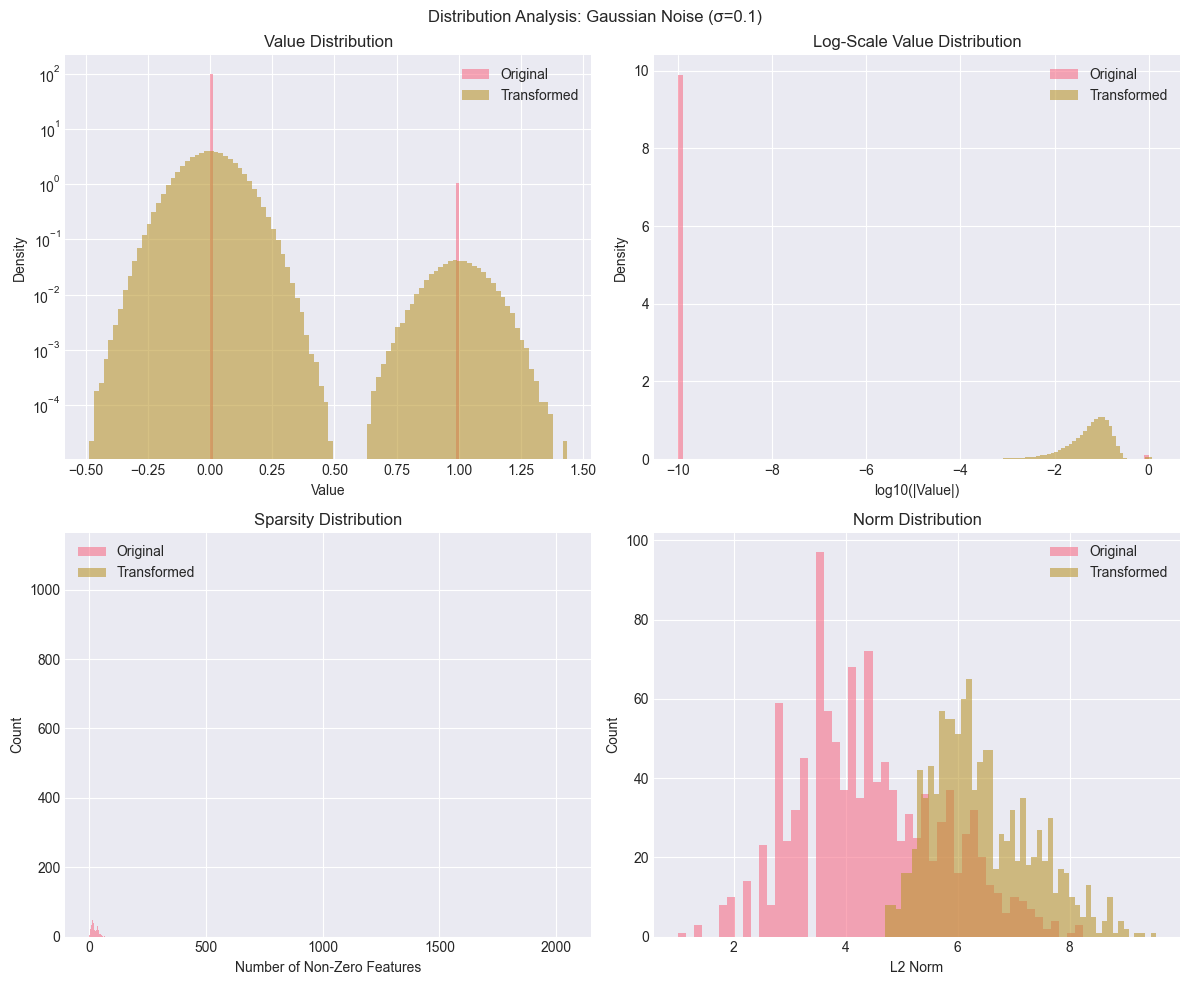

In [34]:
# Visualization
plot_value_distributions(
    binary_dataset.features.cpu().numpy(),
    noisy_dataset.features.cpu().numpy(),
    transform_name="Gaussian Noise (σ=0.1)"
)

In [35]:
# Summary table
noise_summary = pd.DataFrame({
    'Metric': ['Tanimoto', 'Continuous Tanimoto', 'Euclidean', 'Cosine'],
    'Correlation': [
        noise_distances['tanimoto']['correlation'],
        noise_distances['continuous_tanimoto']['correlation'],
        noise_distances['euclidean']['correlation'],
        noise_distances['cosine']['correlation']
    ]
})

display(Markdown("### Distance Preservation Summary (Gaussian Noise)"))
display(noise_summary.style.format({'Correlation': '{:.4f}'}))

### Distance Preservation Summary (Gaussian Noise)

,Metric,Correlation
0,Tanimoto,0.9084
1,Continuous Tanimoto,0.2445
2,Euclidean,0.9897
3,Cosine,0.9027


### 3.3 Normalization: L2 Normalization

**Hypothesis**: L2 normalization creates denser representations and may improve performance by putting all vectors on the unit sphere.

In [36]:
# Create L2 normalization transformation
l2_norm = L2Normalization()

# Apply to a copy of the dataset
print("Applying L2 NORMALIZATION transformation...")
l2_dataset = ECFPDataset(
    name="esol",
    split_type="random",
    target_index=0,
    n_bits=2048,
    radius=2,
    use_count=False
)
l2_dataset.apply_transform(l2_norm)
print("✓ Transformation applied")

Applying L2 NORMALIZATION transformation...
✓ Transformation applied


In [37]:
# Downstream task performance
print("Training MLP on L2-NORMALIZED ECFPs...\n")
l2_result = run_downstream_task(
    l2_dataset,
    task_type="regression",
    hidden_dim=128,
    epochs=100,
    lr=1e-3,
    device="cpu"
)

print("\n" + "="*60)
print("DOWNSTREAM PERFORMANCE COMPARISON")
print("="*60)
print(f"Original - Val RMSE: {binary_result['val']:.4f}")
print(f"L2 Norm  - Val RMSE: {l2_result['val']:.4f}")
print(f"Change: {l2_result['val'] - binary_result['val']:+.4f}")
print("="*60)

Training MLP on L2-NORMALIZED ECFPs...


DOWNSTREAM PERFORMANCE COMPARISON
Original - Val RMSE: 1.1088
L2 Norm  - Val RMSE: 1.1256
Change: +0.0168


In [38]:
# Distance preservation analysis
print("\nAnalyzing distance preservation...\n")
l2_distances = analyze_distance_preservation(
    binary_dataset,
    l2_dataset,
    metrics=["tanimoto", "continuous_tanimoto", "euclidean", "cosine"],
    correlation_method="spearman",
    sample_size=500
)


Analyzing distance preservation...

Using 500 randomly sampled molecules (same samples for both datasets)

Analyzing tanimoto distance preservation...
  Computing tanimoto distances on original dataset...
  Computing tanimoto distances on transformed dataset...
  Spearman correlation: 0.9940 (p=0.00e+00)
  -> Excellent preservation!

Analyzing continuous_tanimoto distance preservation...
  Computing continuous_tanimoto distances on original dataset...
  Computing continuous_tanimoto distances on transformed dataset...
  Spearman correlation: 0.9980 (p=0.00e+00)
  -> Excellent preservation!

Analyzing euclidean distance preservation...
  Computing euclidean distances on original dataset...
  Computing euclidean distances on transformed dataset...
  Spearman correlation: 0.0241 (p=1.51e-17)
  -> Poor preservation

Analyzing cosine distance preservation...
  Computing cosine distances on original dataset...
  Computing cosine distances on transformed dataset...
  Spearman correlation: 1.

In [39]:
# Sparsity analysis
l2_sparsity = compare_sparsity(binary_dataset, l2_dataset)


=== Sparsity Analysis ===

Original ECFP:
  zero_fraction: 0.9895
  nonzero_per_sample: 21.4938
  gini_coefficient: 0.9895
  coefficient_of_variation: 9.7100
  mean: 0.0105
  std: 0.1019
  min: 0.0000
  max: 1.0000

Transformed ECFP:
  zero_fraction: 0.9895
  nonzero_per_sample: 21.4938
  gini_coefficient: 0.9911
  coefficient_of_variation: 10.1037
  mean: 0.0022
  std: 0.0220
  min: 0.0000
  max: 1.0000

Changes:
  Delta zero_fraction: +0.0000 (+0.0%)
  Delta nonzero_per_sample: +0.0000 (+0.0%)
  Delta gini_coefficient: +0.0016 (+0.2%)
  Delta coefficient_of_variation: +0.3938 (+4.1%)
  Delta mean: -0.0083 (-79.3%)
  Delta std: -0.0799 (-78.4%)
  Delta min: +0.0000 (+0.0%)
  Delta max: +0.0000 (+0.0%)


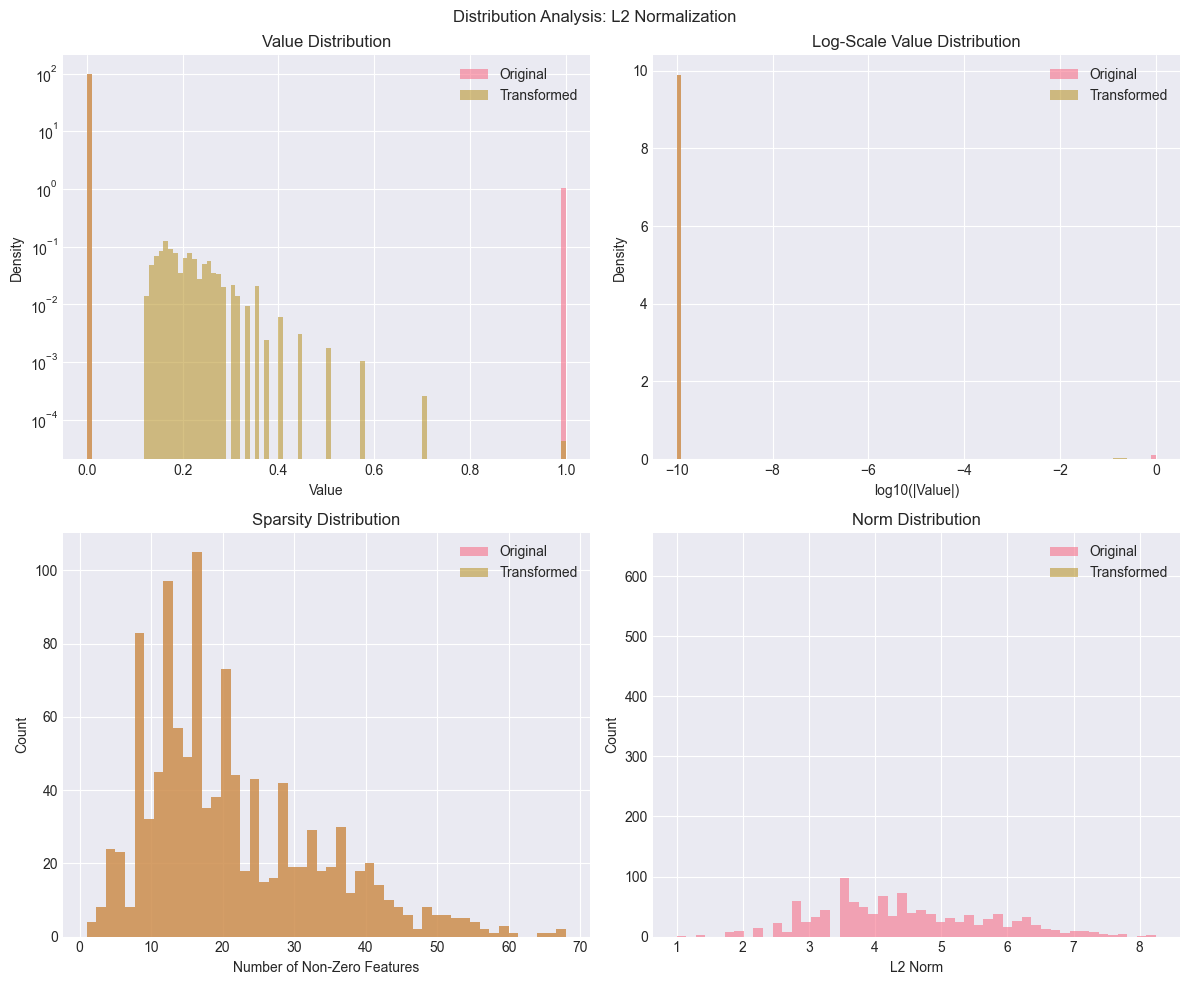

In [40]:
# Visualization
plot_value_distributions(
    binary_dataset.features.cpu().numpy(),
    l2_dataset.features.cpu().numpy(),
    transform_name="L2 Normalization"
)

In [41]:
# Summary table
l2_summary = pd.DataFrame({
    'Metric': ['Tanimoto', 'Continuous Tanimoto', 'Euclidean', 'Cosine'],
    'Correlation': [
        l2_distances['tanimoto']['correlation'],
        l2_distances['continuous_tanimoto']['correlation'],
        l2_distances['euclidean']['correlation'],
        l2_distances['cosine']['correlation']
    ]
})

display(Markdown("### Distance Preservation Summary (L2 Normalization)"))
display(l2_summary.style.format({'Correlation': '{:.4f}'}))

### Distance Preservation Summary (L2 Normalization)

,Metric,Correlation
0,Tanimoto,0.9940
1,Continuous Tanimoto,0.9980
2,Euclidean,0.0241
3,Cosine,1.0000


### 3.4 GNN-Inspired: Block Radius Linear Mixing

**Hypothesis**: Processing each radius block (r=0, r=1, r=2) separately with orthogonal maps + nonlinearity mimics GNN layer-wise processing. This should create more GNN-like representations while respecting the hierarchical structure of ECFP generation.

In [42]:
# Create multi-radius ECFP dataset
print("Creating MULTI-RADIUS ECFP dataset...")
print("  - Using radius=2 (3 blocks: r=0, r=1, r=2)")
print("  - Each block: 512 bits")
print("  - Total: 1536 bits")

multi_radius_dataset = ECFPDataset(
    name="esol",
    split_type="random",
    target_index=0,
    radius=2,
    n_bits=6144,  # 3 blocks × 512 bits
    use_count=False,
    multi_radius=True,  # Enable radius-delta fingerprints
    n_bits_per_radius=2048
)

print(f"  ✓ Dataset: {len(multi_radius_dataset.features)} molecules")
print(f"  ✓ Feature dim: {multi_radius_dataset.features.shape[1]}")
print(f"  ✓ Radius blocks: {multi_radius_dataset.radius_schema.blocks}")

# Create Block Radius Linear Mixing transformation
print("\nCreating Block Radius Linear Mixing...")
print("  - Orthogonal map per radius block")
print("  - ReLU nonlinearity")
print("  - L2 normalization")

block_mixing = BlockRadiusLinearMixing(
    radius_blocks=multi_radius_dataset.radius_schema.blocks,
    nonlinearity="relu",
    seed=42
)

print("✓ Transformation created")

Creating MULTI-RADIUS ECFP dataset...
  - Using radius=2 (3 blocks: r=0, r=1, r=2)
  - Each block: 512 bits
  - Total: 1536 bits
  ✓ Dataset: 1128 molecules
  ✓ Feature dim: 6144
  ✓ Radius blocks: [(0, 2048), (2048, 4096), (4096, 6144)]

Creating Block Radius Linear Mixing...
  - Orthogonal map per radius block
  - ReLU nonlinearity
  - L2 normalization
✓ Transformation created


In [43]:
# Baseline: Train on multi-radius ECFPs without transformation
print("Training MLP on ORIGINAL MULTI-RADIUS ECFPs...\n")
multi_radius_baseline = run_downstream_task(
    multi_radius_dataset,
    task_type="regression",
    hidden_dim=128,
    epochs=100,
    lr=1e-3,
    device="cpu"
)

print(f"\n  Multi-Radius Baseline Performance:")
print(f"    Val RMSE:  {multi_radius_baseline['val']:.4f}")
print(f"    Test RMSE: {multi_radius_baseline['test']:.4f}")

Training MLP on ORIGINAL MULTI-RADIUS ECFPs...


  Multi-Radius Baseline Performance:
    Val RMSE:  1.1536
    Test RMSE: 1.0853


In [44]:
# Apply Block Radius Linear Mixing
print("Applying BLOCK RADIUS LINEAR MIXING...")
block_mixed_dataset = ECFPDataset(
    name="esol",
    split_type="random",
    target_index=0,
    radius=2,
    n_bits=6144,
    use_count=False,
    multi_radius=True,
    n_bits_per_radius=2048
)
block_mixed_dataset.apply_transform(block_mixing)
print("✓ Transformation applied")

# Train on transformed ECFPs
print("\nTraining MLP on BLOCK-MIXED ECFPs...\n")
block_mixed_result = run_downstream_task(
    block_mixed_dataset,
    task_type="regression",
    hidden_dim=128,
    epochs=100,
    lr=1e-3,
    device="cpu"
)

print("\n" + "="*60)
print("DOWNSTREAM PERFORMANCE COMPARISON")
print("="*60)
print(f"Multi-Radius Original - Val RMSE: {multi_radius_baseline['val']:.4f}")
print(f"Block Mixed           - Val RMSE: {block_mixed_result['val']:.4f}")
print(f"Change: {block_mixed_result['val'] - multi_radius_baseline['val']:+.4f}")
print("="*60)

Applying BLOCK RADIUS LINEAR MIXING...
✓ Transformation applied

Training MLP on BLOCK-MIXED ECFPs...


DOWNSTREAM PERFORMANCE COMPARISON
Multi-Radius Original - Val RMSE: 1.1536
Block Mixed           - Val RMSE: 0.9814
Change: -0.1722


In [45]:
# Distance preservation analysis
print("\nAnalyzing distance preservation...\n")
block_mixed_distances = analyze_distance_preservation(
    multi_radius_dataset,
    block_mixed_dataset,
    metrics=["tanimoto", "continuous_tanimoto", "euclidean", "cosine"],
    correlation_method="spearman",
    sample_size=500
)


Analyzing distance preservation...

Using 500 randomly sampled molecules (same samples for both datasets)

Analyzing tanimoto distance preservation...
  Computing tanimoto distances on original dataset...
  Computing tanimoto distances on transformed dataset...
  Spearman correlation: 0.9734 (p=0.00e+00)
  -> Excellent preservation!

Analyzing continuous_tanimoto distance preservation...
  Computing continuous_tanimoto distances on original dataset...
  Computing continuous_tanimoto distances on transformed dataset...
  Spearman correlation: 0.9593 (p=0.00e+00)
  -> Excellent preservation!

Analyzing euclidean distance preservation...
  Computing euclidean distances on original dataset...
  Computing euclidean distances on transformed dataset...
  Spearman correlation: -0.0156 (p=3.49e-08)
  -> Poor preservation

Analyzing cosine distance preservation...
  Computing cosine distances on original dataset...
  Computing cosine distances on transformed dataset...
  Spearman correlation: 0

In [46]:
# Sparsity analysis
block_mixed_sparsity = compare_sparsity(multi_radius_dataset, block_mixed_dataset)


=== Sparsity Analysis ===

Original ECFP:
  zero_fraction: 0.9965
  nonzero_per_sample: 21.4938
  gini_coefficient: 0.9965
  coefficient_of_variation: 16.8775
  mean: 0.0035
  std: 0.0590
  min: 0.0000
  max: 1.0000

Transformed ECFP:
  zero_fraction: 0.5063
  nonzero_per_sample: 3033.1232
  gini_coefficient: 0.7143
  coefficient_of_variation: 1.4981
  mean: 0.0071
  std: 0.0106
  min: 0.0000
  max: 0.1148

Changes:
  Delta zero_fraction: -0.4902 (-49.2%)
  Delta nonzero_per_sample: +3011.6294 (+14011.6%)
  Delta gini_coefficient: -0.2822 (-28.3%)
  Delta coefficient_of_variation: -15.3794 (-91.1%)
  Delta mean: +0.0036 (+102.5%)
  Delta std: -0.0484 (-82.0%)
  Delta min: +0.0000 (+0.0%)
  Delta max: -0.8852 (-88.5%)


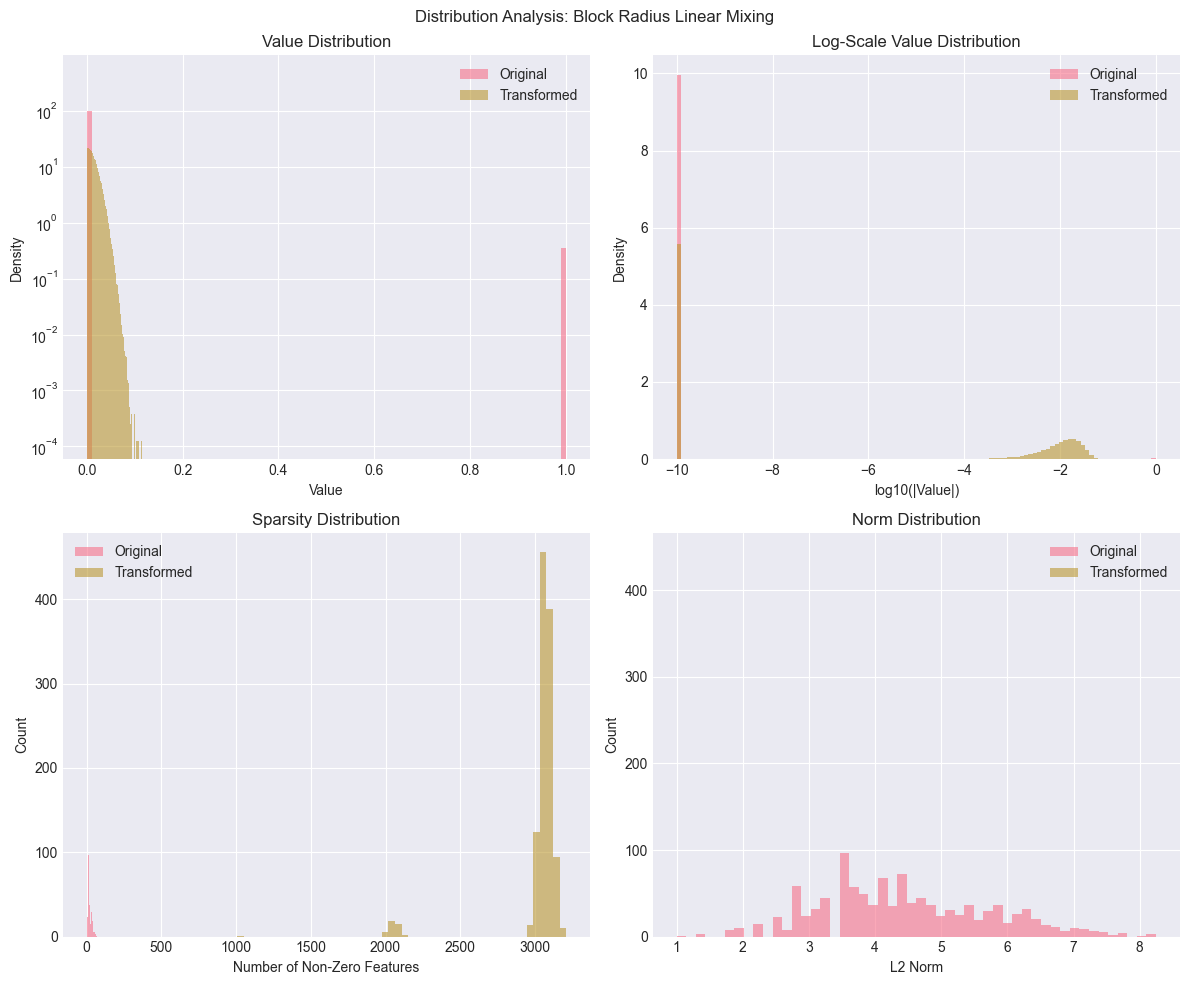

In [47]:
# Visualization
plot_value_distributions(
    multi_radius_dataset.features.cpu().numpy(),
    block_mixed_dataset.features.cpu().numpy(),
    transform_name="Block Radius Linear Mixing"
)

In [48]:
# Summary table
block_mixed_summary = pd.DataFrame({
    'Metric': ['Tanimoto', 'Continuous Tanimoto', 'Euclidean', 'Cosine'],
    'Correlation': [
        block_mixed_distances['tanimoto']['correlation'],
        block_mixed_distances['continuous_tanimoto']['correlation'],
        block_mixed_distances['euclidean']['correlation'],
        block_mixed_distances['cosine']['correlation']
    ]
})

display(Markdown("### Distance Preservation Summary (Block Radius Linear Mixing)"))
display(block_mixed_summary.style.format({'Correlation': '{:.4f}'}))

### Distance Preservation Summary (Block Radius Linear Mixing)

,Metric,Correlation
0,Tanimoto,0.9734
1,Continuous Tanimoto,0.9593
2,Euclidean,-0.0156
3,Cosine,0.9681


**Key Insights**:

- Block Radius Linear Mixing mimics GNN layer-wise processing
- Each radius (r=0, r=1, r=2) gets its own orthogonal transformation
- Preserves hierarchical structure from ECFP generation
- Nonlinearity + L2 norm creates more GNN-like representations
- Compares multi-radius delta ECFPs (where each block contains only substructures unique to that radius)